# Build wavelet

Edited by Louise, 28-02-2023

Show how to load wavelets from s2wav.

In [6]:
from jax import jit, config

import s2fft

config.update("jax_enable_x64", True)

import numpy as np
from matplotlib import pyplot as plt

from s2wav.filter_factory.filters import filters_directional_vectorised
from s2wav.filter_factory.filters import filters_axisym_vectorised

# Parameters

In [26]:
sampling = "mw"
multiresolution = True
reality = True
nside = 16
L = 3 * nside
N = 3
J_min = 0



# Make axisymmetric wavelets

(7, 48) (48,)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


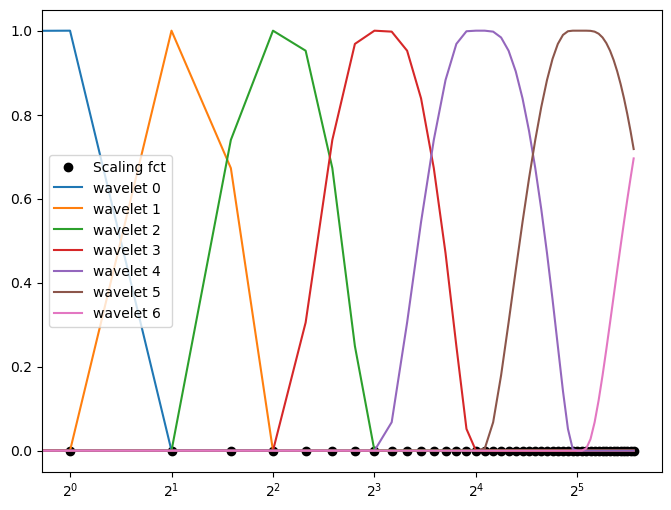

In [40]:
wlm, slm = filters_axisym_vectorised(L, J_min)
print(wlm.shape, slm.shape)
print(slm)

plt.figure(figsize=(8, 6))
plt.plot(slm, 'ko', label='Scaling fct')
for j in range(7):
    plt.plot(np.real(wlm)[j, :], label=f'wavelet {j}')
plt.xscale('log', base=2)
plt.legend()

In [41]:
j = 4
w = s2fft.inverse_jax(wlm[j, :], L=L)
print(w.shape)
s2fft.utils.plotting_functions.plot_sphere(w, L, sampling, isnotebook=True)

ValueError: Einstein sum subscript 'lm' does not contain the correct number of indices for operand 0.

# Make directional wavelets

Note that you can make axisym wavelet with the directionnal function, only set N=1.
But normalisations are differents so then if you use the convolution, you need to use the directional convolution.

(7, 48, 95) (48,)


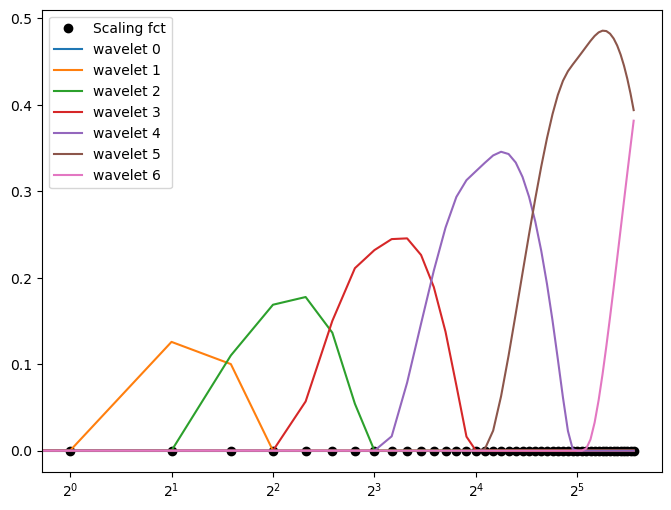

In [32]:
wlm, slm = filters_directional_vectorised(L, N, J_min)
print(wlm.shape, slm.shape)

m = L-1

plt.figure(figsize=(8, 6))
plt.plot(slm, 'ko', label='Scaling fct')
for j in range(7):
    plt.plot(np.real(wlm)[j, :, m], label=f'wavelet {j}')
plt.xscale('log', base=2)
plt.legend()

In [34]:
j = 4
w = s2fft.inverse_jax(wlm[j, :, :], L=L)
print(w.shape)
s2fft.utils.plotting_functions.plot_sphere(w, L, sampling, isnotebook=True)

(48, 95)


Widget(value="<iframe src='http://localhost:39521/index.html?ui=P_0x7fec8424c400_0&reconnect=auto' style='widt…

In [42]:
import jax.numpy as jnp
b=1+3.j
jnp.mean(b)

Array(1.+3.j, dtype=complex128)